# GraphSHAPer implementation

Explain the graph classification using Shaply values for edges.
Determine the contribution of each edge towards the output value (predicted problability)

Starting point:

TODO:

* Method 1 (jackknife-style sampling): compute approx shapley value for edge $e$ considering all possibile coalitions of $E - 1$ edges, where $E$ is the number of edges.
* Method 2 (montecarlo sampling)
* Method 3 (exahustive search)
* Method 4 (node sampling): sample a number of nodes and work in the nodes k-hop subgraph similarly to a node classification explanation 

In [1]:
import torch
from torchdrug import data
import pandas as pd
import numpy as np
import random

from rdkit import Chem
from rdkit.Chem import Draw
from pysmiles import read_smiles
import networkx as nx

from rdkit_heatmaps import mapvalues2mol
from rdkit_heatmaps.utils import transform2png

from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
# for debugging
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## Reproducibility Settings

In [3]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

## Data Loading

In [4]:
DATASET_TYPE = "single" #"single", dual
TARGET = 1
TRAINING_SET_SPLIT = "FULL" #None, FULL, 0, 1, 2
MODEL_NUM = 0 #2 with single targe 1 vs random
SAVE = True
TARGET_CPDS = "P14416_P42336" #"P14416_P42336 (single) #P27338_P22303 P27338_P29274 Q9Y5N1_P31645 (dual)
DATASET_NAME = "chembl29_predicting_target_" + TARGET_CPDS + "_target_"+ str(TARGET) +"_vs_random_cpds" #"chembl29_dt_cpds_" + TARGET_CPDS + "_balanced" #"chembl29_predicting_target_" + TARGET_CPDS + "_target_"+ str(TARGET) +"_vs_random_cpds" # "chembl29_dt_cpds_" + TARGET_CPDS + "_balanced" #"chembl29_predicting_target_P14416_P42336_target_1_vs_random_cpds"
CSV_DATA_PATH = "../data/"+ DATASET_NAME + ".csv"

smiles_df = pd.read_csv(CSV_DATA_PATH, sep = ",")
display(smiles_df.head())
display(smiles_df.shape)

,nonstereo_aromatic_smiles,target_pair,label
0,Brc1ccc(CNCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1,P14416_P42336,0
1,Brc1ccc(N2CCN(Cc3ccccc3)CC2)c2cc[nH]c12,P14416_P42336,0
2,Brc1ccc(NCCN2CCN(CCc3c[nH]c4ccccc34)CC2)cc1,P14416_P42336,0
3,Brc1ccc(NCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1,P14416_P42336,0
4,Brc1cccc(N2CCN(Cc3cc4ccccn4n3)CC2)n1,P14416_P42336,0


(8348, 3)

## Define Custom Class
We need to define the ChEMBL datasets class in order to load the model

In [5]:
import os

from torchdrug.core import Registry as R
from torchdrug.utils import doc


@R.register("datasets.ChEMBL") #only first time you launch the class
#@doc.copy_args(data.MoleculeDataset.load_csv, ignore=("path", "smiles_field", "target_fields"))
class ChEMBL(data.MoleculeDataset):
    

    def __init__(self, path, smiles_field, target_fields, verbose=1, **kwargs):
        # path = os.path.expanduser(path)# if not os.path.exists(path):
        #     os.makedirs(path)
        self.path = path
        self.smiles_field = smiles_field
        self.target_fields= target_fields
        #print(self.path)
        # zip_file = utils.download(self.url, path, md5=self.md5)
        # csv_file = utils.extract(zip_file)

        self.load_csv(self.path, smiles_field=self.smiles_field, target_fields=self.target_fields,
                      verbose=verbose, **kwargs)

In [6]:
#target_fields = ["target1", "target2"] if DATASET_TYPE == "dual" else ["label"]
target_fields = ["label"]
chembl_dataset = ChEMBL(path = CSV_DATA_PATH, smiles_field = "nonstereo_aromatic_smiles", target_fields = target_fields)

Loading ../data/chembl29_predicting_target_P14416_P42336_target_1_vs_random_cpds.csv: 100%|██████████| 8349/8349 [00:00<00:00, 47559.88it/s]
Constructing molecules from SMILES:  54%|█████▍    | 4492/8348 [00:19<00:16, 236.40it/s]c:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\lib\site-packages\torchdrug\data\feature.py:37: UserWarning: Unknown value `Na`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES: 100%|██████████| 8348/8348 [00:35<00:00, 236.45it/s]


## Obtain edge index to use with PyG

Visualize molecules using NetworkX

In [7]:
smiles = chembl_dataset.smiles_list
mols = []
for i in tqdm(range(len(chembl_dataset.smiles_list))):
    mols.append(read_smiles(chembl_dataset.smiles_list[i]))

# mol = mols[0]
# print(mol.nodes(data='element'))
# labels = nx.get_node_attributes(mol, 'element') 
# nx.draw(mol, labels = labels, pos=nx.spring_layout(mol))

  0%|          | 0/8348 [00:00<?, ?it/s]

Define edge index 

In [8]:
edge_index_list = []

for mol in tqdm(mols):
    adj = nx.to_scipy_sparse_matrix(mol).tocoo()
    row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
    col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
    edge_index = torch.stack([row, col], dim=0)
    edge_index_list.append(edge_index)

display(len(mols))

  0%|          | 0/8348 [00:00<?, ?it/s]

8348

Define torchdrug dataset in order to get node features

In [9]:
mols_torchdrug_format = []
for i in tqdm(range(len(chembl_dataset.smiles_list))):
    mols_torchdrug_format.append(data.Molecule.from_smiles(chembl_dataset.smiles_list[i], with_hydrogen = False))


  0%|          | 0/8348 [00:00<?, ?it/s]

c:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\lib\site-packages\torchdrug\data\feature.py:37: UserWarning: Unknown value `Na`
  warnings.warn("Unknown value `%s`" % x)


## Create Custom Dataset

In [10]:
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data

from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_list = []
y = torch.LongTensor(chembl_dataset.targets["label"]).to(device)

for i in tqdm(range(len(mols))):
    data_list.append(Data(x = mols_torchdrug_format[i].node_feature, edge_index = edge_index_list[i], y = y[i], smiles = chembl_dataset.smiles_list[i]))


  0%|          | 0/8348 [00:00<?, ?it/s]

In [11]:
class ChEMBLDatasetPyG(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None, data_list = None):
        super().__init__(root, transform, pre_transform, pre_filter)
        #self.data, self.slices = torch.load(self.processed_paths[0])
        self.data_list = data_list

        # Read data into huge `Data` list.
        data_list = self.data_list

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.data, self.slices = self.collate(data_list)
        

In [12]:
dataset = ChEMBLDatasetPyG(".", data_list = data_list)

Split data in train/val/test (0.8/0.1/0.1)

In [13]:
lengths = [int(0.8 * len(chembl_dataset)), int(0.1 * len(chembl_dataset))]
lengths += [len(chembl_dataset) - sum(lengths)]

print(lengths)
dataset = dataset.shuffle()
train_data = dataset[:lengths[0]]
val_data = dataset[lengths[0]+1:lengths[0] + lengths[1]+1]
test_data = dataset[lengths[0] + lengths[1] + 1: ]  #we add +1 otherwise the last sample of the validation falls in the test too.
len(train_data), len(val_data), len(test_data)

[6678, 834, 836]


(6678, 834, 835)

In [14]:
batch_size= 32
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [15]:
# for i in range(len(train_data)):
#     print(train_data[i].smiles)

In [16]:
# for i in range(len(val_data)):
#     print(val_data[i].smiles)

In [17]:
# for i in range(len(test_data)):
#     print(test_data[i].smiles)

## GCN Definition

In [15]:
from torch_geometric.nn import GCNConv, Linear
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(chembl_dataset.node_feature_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=256).to(device)
print(model)

GCN(
  (conv1): GCNConv(69, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 256)
  (conv4): GCNConv(256, 256)
  (lin): Linear(in_features=256, out_features=2, bias=True)
)


## Load the Model

In [16]:
import os.path as osp

if TRAINING_SET_SPLIT == None:
    MODEL_PATH = "../models/PyG/" + DATASET_NAME + "_model_" + str(MODEL_NUM) + ".ckpt"
else:
    MODEL_PATH = "../models/PyG/" + DATASET_NAME + "_training_set_" + str(TRAINING_SET_SPLIT) + "_model_" + str(MODEL_NUM) + ".ckpt"
ckpt_path = osp.join(MODEL_PATH)
model.load_state_dict(torch.load(ckpt_path))
model.to(device)

GCN(
  (conv1): GCNConv(69, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 256)
  (conv4): GCNConv(256, 256)
  (lin): Linear(in_features=256, out_features=2, bias=True)
)

## Test the Model

In [17]:
def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         data = data.to(device)
         
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

test_acc = test(test_loader)    
print(f'Test Acc: {test_acc:.4f}')

####THIS IS NOT THE TEST USED BY THE LOADED MODEL, WE NEED TO BE COHERENT AND USE THE SAME TRAIN,VAL AND TEST SETS############## TODO later, the focus now in explainability

Test Acc: 0.9749


## GraphSHAPer

* Players = edges
* Value = predicted probability $v$
* $E$ = set of all edges
* $v(E)$ = value of all the edges == original predicted prob
* $\phi_m(v)$ = payout for the contribution of edge m
* $S$ = all the possible subset of edges excluding m
* |S| = size of S
* $v(S)$ is the value achieved by subset S
* $v(S∪{m})$ is the realized value after m joins S

Shapley values compouted as:

$\phi_m(v) = \frac{1}{|E|} \sum_S \frac{v(S \cup {m}) - v(S)}{\binom{|E|-1}{|S|}}$

Oc1nc2c(N3CCN(Cc4ccccc4)CC3)cccc2[nH]1
tensor([[10.3128, -9.9729]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[1.0000e+00, 1.5489e-09]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


0

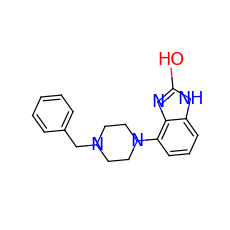

In [30]:
#test nums 78, 89, 2 is predicted to interact with target cpd, sample 0 is random for single target dataset with target 1. class 0 interacts, class 1 is random
# 78 is predicted to interact with target for dataset with target 2. 0 interacts with random
# for dual target Q9Y5N1_P31645 sample 0 has class 0
# for dual target P27338_P29274 sample 0 is class 0
# for dual targe P27338_P22303 sample 4 is class 0
test_set_index = 89 #112 #458 #89 #121
test_cpd = test_data[test_set_index].to(device)
print(test_cpd.smiles)
mol_test = data.Molecule.from_smiles(test_cpd.smiles, with_hydrogen=False)
mol_test.visualize()

model.eval()
# all nodes belong to same graph
batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
out = model(test_cpd.x, test_cpd.edge_index, batch=batch)
out_prob = F.softmax(out, dim = 1)
target_class = torch.argmax(out_prob[0]).item()
print(out)
print(out_prob)
target_class

Creating folder and saving smiles

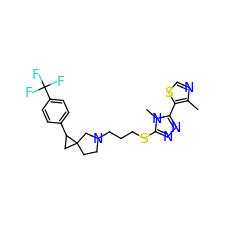

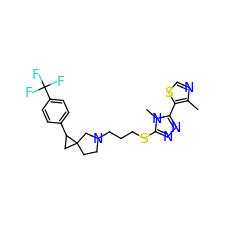

In [22]:
if SAVE:
    
    if DATASET_TYPE == "dual":
        FOLDER_NAME = "../results/explanations/" + DATASET_TYPE + "/" + TARGET_CPDS
    else:
        FOLDER_NAME = "../results/explanations/" + DATASET_TYPE + "/" + TARGET_CPDS +"/Target " + str(TARGET) + " vs Random"

    CPD_FOLDER_NAME = FOLDER_NAME + "/" + test_cpd.smiles

    if not os.path.exists(FOLDER_NAME):
        os.mkdir(FOLDER_NAME)

    if not os.path.exists(CPD_FOLDER_NAME):
        os.mkdir(CPD_FOLDER_NAME)


    mol_test.visualize(save_file = CPD_FOLDER_NAME + "/" + test_cpd.smiles + ".png")

mol_test.visualize()

In [31]:
print(test_cpd.edge_index)
print(test_cpd.edge_index.shape)

tensor([[ 0,  1,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,  6,  6,  7,
          7,  8,  8,  8,  9,  9, 10, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15,
         15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 21, 22, 22],
        [ 1,  0,  2, 22,  1,  3,  2,  4, 21,  3,  5, 18,  4,  6, 17,  5,  7,  6,
          8,  7,  9, 16,  8, 10,  9, 11, 15, 10, 12, 11, 13, 12, 14, 13, 15, 10,
         14,  8, 17,  5, 16,  4, 19, 18, 20, 19, 21,  3, 20, 22,  1, 21]],
       device='cuda:0')
torch.Size([2, 52])


### Jackknife approx

* $S = E/\{m\}$
* $ v(S \cup {m}) = v(E)$ # since if we add m back we obtain the original graph

In [24]:
# from scipy.special import binom

# v_E = out_prob[0][target_class].item()
# E = test_cpd.edge_index
# phi_edges = []
# v_S_u_m = v_E

# for i in tqdm(range(E.shape[1])):
#     # node_source = E[0][i]
#     # node_to = E[1][i]
#     #S = E[0:,i:]
#     S = torch.cat([E[0:,0:i], E[0:,i+1:]], dim = 1)
#     batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
#     out = model(test_cpd.x, S, batch=batch) #we use S as edge index
#     out_prob = F.softmax(out, dim = 1)
#     v_S = out_prob[0][target_class].item()

#     denominator = binom(E.shape[1] - 1, 1)

#     shapley_value = (1/E.shape[1]) * ((v_S_u_m - v_S) / denominator) #jackknife approximation
#     phi_edges.append(shapley_value)

# sum(phi_edges)


In [25]:
# phi_edges

### Montecarlo Sampling

See https://christophm.github.io/interpretable-ml-book/shapley.html#estimating-the-shapley-value and https://link.springer.com/article/10.1007/s10115-013-0679-x

Inseatd of randmly sampling sample $z$ from the data (that for use is nonsense) we create a random graph $Z$ according to a problability distribution.
We add an edge according to the probability of an edge to exists in the explained graph G.

Pseudo code:

Output: Shapley value for j-th edge
Required: number of iterations M, graph to explain $G(N_g, E_g)$, edge list E, edge index j, edge_probability_distribution, GNN model

$\forall\space m \in {0,...,M-1}$

* create random graph $Z(N_z,E_z)$, where $N_z = N_g$ and with $E_z$ are such that $z \in E_z | e \sim \mathbf{P}$, where $\mathbf{P}$ is the probablity distrubution of an edge to exist. (can be domain-specific, depends on atoms!)
* Choose a random permutation $\pi$ of the egdes
* Order edges list $E_g$: $E_g^{\phi}: (e_0,...,e_j,...,e_{|E_g|-1})$
* Order edges list $E_z$: $E_z^{\phi}: (z_0,...,z_j,...,z_{|E_z|-1})$
* Constuct the two new edge lists:
    * With index $j: E_{+j} = (e_0,...,e_j,z_{j+1}...,z_{|E_z|-1})$
    * Without index $j: E_{-j} = (e_0,...,e_{j-1}, z_j,z_{j+1}...,z_{|E_z|-1})$
* Compute marginal contribution: $\phi_j^m = \hat{f}(E_{+j}) - \hat{f}(E_{+j})$
* Compute Shapley values as the avb: $\phi_j(G) = \frac{1}{M} \sum_{m=0}^{M-1} \phi_{j}^{m}$

where $\hat{f}$ is the function learned by the GNN

number of max edges in directed graph: n*(n-1)

number of max edges in undirected graph: (n*(n-1))/2

### Define edge probablility
We approximate it by using the graph desinity. This is a rather brutal approximation, a domain-specific approach would work probably better (e.g. atoms involved etc)

In [32]:
E = test_cpd.edge_index
num_nodes = test_cpd.x.shape[0]
max_num_edges = num_nodes*(num_nodes-1)
num_edges = E.shape[1]
graph_density = num_edges/max_num_edges
P = graph_density #this is to be discussed and mention in paper

In [33]:
M = 200 #200
TOL = 10e-3
phi_edges = []
phi_edges_current = [0] * num_edges
model.eval()
batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
out = model(test_cpd.x, test_cpd.edge_index, batch=batch)
out_prob_real = F.softmax(out, dim = 1)[0][target_class].item()

# marginal_contrib = 0
from numpy.random import default_rng
rng = default_rng(seed = 42) #to seed or not to seed?
model.eval()

log_odds = False
for i in tqdm(range(M)):
    
    for j in range(num_edges):
        #marginal_contrib = 0
        
        E_z_mask = rng.binomial(1, P, num_edges)
        #E_z_index = torch.IntTensor(torch.nonzero(torch.IntTensor(E_z_mask)).tolist()).to(device).squeeze()
        #E_z = torch.index_select(E, dim = 1, index = E_z_index)
        E_mask = torch.ones(num_edges)
        pi = torch.randperm(num_edges)

        E_j_plus_index = torch.ones(num_edges, dtype=torch.int)
        E_j_minus_index = torch.ones(num_edges, dtype=torch.int)
        selected_edge_index = np.where(pi == j)[0].item()
        for k in range(num_edges):
            if k <= selected_edge_index:
                E_j_plus_index[pi[k]] = E_mask[pi[k]]
            else:
                E_j_plus_index[pi[k]] = E_z_mask[pi[k]]

        for k in range(num_edges):
            if k < selected_edge_index:
                E_j_minus_index[pi[k]] = E_mask[pi[k]]
            else:
                E_j_minus_index[pi[k]] = E_z_mask[pi[k]]


        #we compute marginal contribs
        
        # with edge j
        retained_indices_plus = torch.LongTensor(torch.nonzero(E_j_plus_index).tolist()).to(device).squeeze()
        E_j_plus = torch.index_select(E, dim = 1, index = retained_indices_plus)

        batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
        
        out = model(test_cpd.x, E_j_plus, batch=batch)
        out_prob = None

        if not log_odds:
            out_prob = F.softmax(out, dim = 1)
        else:
            out_prob = out #out prob variable now containts log_odds
        
        V_j_plus = out_prob[0][target_class].item() #probably the predicted class changes when selecting/deselecing certain edges for class 1: more iterations needed?

        # without edge j
        retained_indices_minus = torch.LongTensor(torch.nonzero(E_j_minus_index).tolist()).to(device).squeeze()
        E_j_minus = torch.index_select(E, dim = 1, index = retained_indices_minus)

        batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
        out = model(test_cpd.x, E_j_minus, batch=batch)

        if not log_odds:
            out_prob = F.softmax(out, dim = 1)
        else:
            out_prob = out
        
        V_j_minus = out_prob[0][target_class].item()

        phi_edges_current[j] += (V_j_plus - V_j_minus)

    #phi_edges.append(marginal_contrib/M)
    phi_edges = [elem / (i+1) for elem in phi_edges_current]
    print(sum(phi_edges))
    if abs(out_prob_real - sum(phi_edges)) <= TOL:
        break     

print("Sampling steps before convergence: ", i)         
print("Sum of Shapley values: ", sum(phi_edges))
print("Predicted prob: ", out_prob_real)

  0%|          | 0/200 [00:00<?, ?it/s]

-0.06780254257532578
0.0043494004662226315
0.8165098278716367
1.043493105937105
1.1969134558142873
1.1422733544166446
0.9128513744874588
1.1785948575881613
0.9582847145692998
1.0911496886892305
1.096146832454417
1.0830001944299363
1.000788789298592
0.8708667852852612
0.753351878997446
0.703077796896014
0.6671007448979792
0.689558781327069
0.7074648293002596
0.7913155319701212
0.7445381456762762
0.7136770751151812
0.6960921903713032
0.6607013239041246
0.7076288900747709
0.7123104850388438
0.7292501326304416
0.7278982843345617
0.6986850399481224
0.7179732496450333
0.7637860305613585
0.7893643096499461
0.7895716523279828
0.81153299680442
0.7450705869764712
0.7375912755149688
0.677738791639011
0.703117854175705
0.7241140689768272
0.8115916112758905
0.8004720683119549
0.8437808223434229
0.8774352192278113
0.9035370259320203
0.9186594148921635
0.9281129628471237
0.8961495601752358
0.8813801729486478
0.863195467304708
0.8397089259164703
0.8298519117654717
0.8282592650312413
0.8156409475152203

In [24]:
abs(out_prob_real - sum(phi_edges))

0.001665674733953848

In [25]:
print(out_prob)
print(phi_edges)

tensor([[0.0801, 0.9199]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
[-0.007593997378383833, 0.22504291248085487, -0.011055542162475257, -0.009741742334682337, 0.009862990598796176, -0.029576243754020345, 0.007724030707336727, -0.0033775861609033173, -0.016557331509500613, -0.012604102327866688, -0.018365331395514235, -0.007180494698864211, -0.007434741041010816, 0.05193908157806794, 0.020110191317483424, 0.023545786865091956, 0.05600200381728214, 0.06581501994872684, 0.010970366321021887, 0.09791942439597773, 0.05857315862225575, 0.12794604158339581, 0.07798268452730711, 0.04364524576549908, 0.01087473322928177, 0.027437469259392618, 0.003914513148221867, 0.0006278318950341025, 0.0007252416409263224, 0.0043139340232096444, -0.0027048349454658407, 0.005028406301148069, 0.00258411952116715, 0.009723490063304401, -0.016337574956707884, -0.015054218091305926, -0.011172334453800668, 0.055712828424767186, 0.04921056836791938, 0.026153694512342455, 0.040191665149815904, 0.0373313845881230

In [29]:
if SAVE:
    INFO_EXPLANATIONS = "info_explanations"
    if TRAINING_SET_SPLIT != None:
        INFO_EXPLANATIONS += "_training_split_" + str(TRAINING_SET_SPLIT)
        
    with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "w+") as saveFile:
        saveFile.write("Test set index: " + str(test_set_index) + "\n\n")

    with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "a") as saveFile:
        saveFile.write("Target Class: " + str(target_class) + "\n\n")

    tagert_compound_sample = "TARGET" if target_class == 0 else "RANDOM"

    with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "a") as saveFile:
        saveFile.write("Target compound: " + str(tagert_compound_sample) + "\n\n")

    with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "a") as saveFile:
        saveFile.write("Sum of Shapley Values: " + str(sum(phi_edges)) + "\n\n")

    with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "a") as saveFile:
        saveFile.write("Shapley values:\n")
        for phi_val in phi_edges:
            saveFile.write(str(phi_val) + "\n")
    with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "a") as saveFile:
        saveFile.write("\nEdge Index:\n")
        saveFile.write(str(test_cpd.edge_index) + "\n\n")
        saveFile.write("Edge index shape: " + str(test_cpd.edge_index.shape) +"\n")

In [30]:
# retained_indices_plus = torch.LongTensor(torch.nonzero(E_j_plus_index).tolist()).to(device).squeeze()
# E_j_plus = torch.index_select(E, dim = 1, index = retained_indices_plus)

# batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
# out = model(test_cpd.x, E_j_plus, batch=batch)
# out_prob = F.softmax(out, dim = 1)

# V_j_plus = out_prob[0][0].item()

# # without edge j
# retained_indices_minus = torch.LongTensor(torch.nonzero(E_j_minus_index).tolist()).to(device).squeeze()
# E_j_minus = torch.index_select(E, dim = 1, index = retained_indices_minus)

# batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
# out = model(test_cpd.x, E_j_minus, batch=batch)
# out_prob = F.softmax(out, dim = 1)

# V_j_minus = out_prob[0][0].item()

# marginal_contrib += (V_j_plus - V_j_minus)

In [31]:
# batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
# out = model(test_cpd.x, test_cpd.edge_index, batch=batch)
# out_prob = F.softmax(out, dim = 1)

## Visualize Explanation

[ 1 21 19 22 17 20 16 37 13 38 23 40 41 43 25 39 15 14 50 46 18 24  4 33
  6 31 29 26 32 44 49 28 27 42 48 30  7 51 11 12  0  3  2 36  9 35 34  8
 47 10 45  5]
[0.22504291248085487, 0.12794604158339581, 0.09791942439597773, 0.07798268452730711, 0.06581501994872684, 0.05857315862225575, 0.05600200381728214, 0.055712828424767186, 0.05193908157806794, 0.04921056836791938, 0.04364524576549908, 0.040191665149815904, 0.037331384588123094, 0.030542616889304083, 0.027437469259392618, 0.026153694512342455, 0.023545786865091956, 0.020110191317483424, 0.017575348992305354, 0.01393226694390487, 0.010970366321021887, 0.01087473322928177, 0.009862990598796176, 0.009723490063304401, 0.007724030707336727, 0.005028406301148069, 0.0043139340232096444, 0.003914513148221867, 0.00258411952116715, 0.001933365454901543, 0.001845338927277953, 0.0007252416409263224, 0.0006278318950341025, -0.0013693822635516555, -0.001595317902735543, -0.0027048349454658407, -0.0033775861609033173, -0.0041390098738771025, -0.0

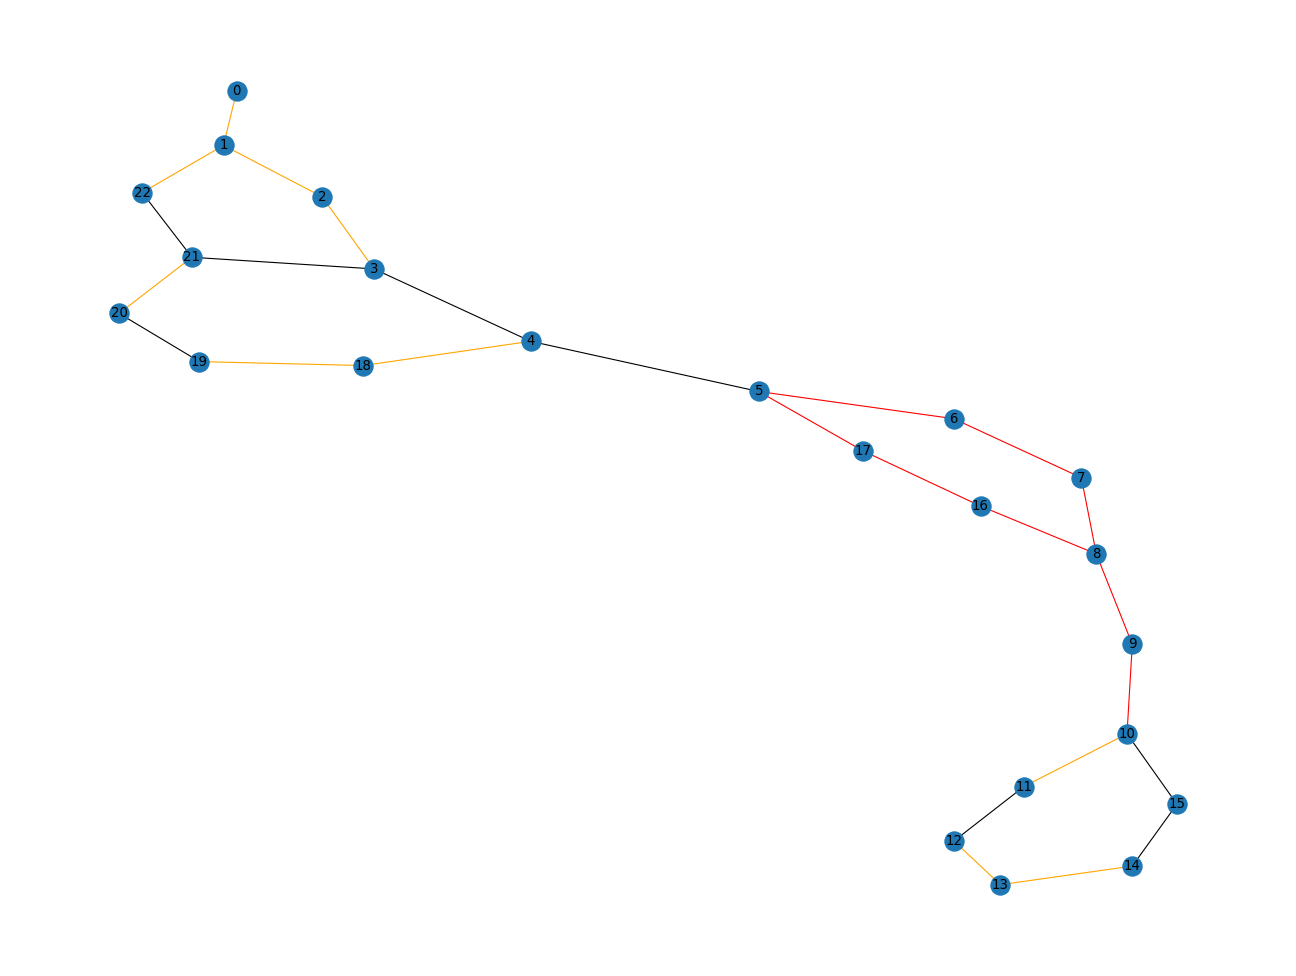

In [26]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

important_edges_ranking = np.argsort(-np.array(phi_edges))
print(important_edges_ranking)
sorted_phi_edges = sorted(phi_edges, reverse = True)
print(sorted_phi_edges)
print(sum(phi_edges))

threshold = np.median(phi_edges) #to discuss when an edge in important or not
hard_edge_mask = (torch.FloatTensor(phi_edges) > threshold).to(torch.float) #>=
print(hard_edge_mask.shape)

important_edges_index = torch.nonzero(hard_edge_mask == 1)
print(important_edges_index)

edge_index = E.to(device)
important_edges_index = important_edges_index.to(device)

important_edges = torch.index_select(edge_index, dim = 1, index = important_edges_index.squeeze())
print(important_edges)

edges_color = []
mol = read_smiles(test_cpd.smiles)

#standard visualization for importan egdes GNNExplainer-like
for edge in mol.edges:
    found_from = False
    found_to = False
    for i in range(important_edges.shape[1]):
        if edge[0] == important_edges[0][i] and edge[1] == important_edges[1][i]:
            found_from = True
        if edge[1] == important_edges[0][i] and edge[0] == important_edges[1][i]:
            found_to = True
    if found_from and found_to:
        edges_color.append("red")
    elif found_from or found_to:
        edges_color.append("orange")
    else:
        edges_color.append("black")   

#visualization for indentifying unimportant edges (edge is important if both directins are above threshold)
# for edge in mol.edges:
#     found_from = False
#     found_to = False
#     for i in range(important_edges.shape[1]):
#         if edge[0] == important_edges[0][i] and edge[1] == important_edges[1][i]:
#             found_from = True
#         if edge[1] == important_edges[0][i] and edge[0] == important_edges[1][i]:
#             found_to = True
#     if found_from and found_to:
#         edges_color.append("red")
#     # elif found_from or found_to:
#     #     edges_color.append("red")
#     else:
#         edges_color.append("black")   

figure(figsize=(16, 12), dpi=80)
#mol = nx.DiGraph(mol)
labels = nx.get_node_attributes(mol, 'element') 
nx.draw(mol, with_labels = True, edge_color = edges_color, pos=nx.spring_layout(mol))

# if SAVE:
#     if TRAINING_SET_SPLIT == None:
#         plt.savefig(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GraphSHAPer_MC_" + str(M), dpi=300, bbox_inches='tight')
#     else:
#         plt.savefig(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GraphSHAPer_MC_" + str(M) + "training_split_" + str(TRAINING_SET_SPLIT), dpi=300, bbox_inches='tight')
    
# plt.show()

## Visualize Explanation - Moleculized

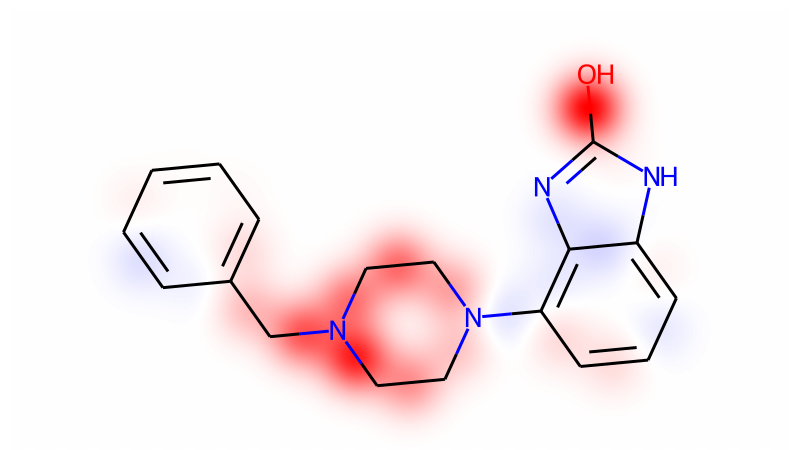

<Figure size 432x288 with 0 Axes>

In [27]:
test_mol = Chem.MolFromSmiles(test_cpd.smiles)
test_mol = Draw.PrepareMolForDrawing(test_mol)

num_bonds = len(test_mol.GetBonds())
num_atoms = len(test_mol.GetAtoms())

rdkit_bonds = {}

for i in range(num_bonds):
    init_atom = test_mol.GetBondWithIdx(i).GetBeginAtomIdx()
    end_atom = test_mol.GetBondWithIdx(i).GetEndAtomIdx()
    bond_type = test_mol.GetBondWithIdx(i).GetBondType()
    #print("Bond: ", i, " " , init_atom, "-" , end_atom, " ", bond_type)
    rdkit_bonds[(init_atom, end_atom)] = i

rdkit_bonds_phi = [0]*num_bonds
for i in range(len(phi_edges)):
    phi_value = phi_edges[i]
    init_atom = edge_index[0][i].item()
    end_atom = edge_index[1][i].item()
    
    if (init_atom, end_atom) in rdkit_bonds:
        bond_index = rdkit_bonds[(init_atom, end_atom)]
        rdkit_bonds_phi[bond_index] += phi_value
    if (end_atom, init_atom) in rdkit_bonds:
        bond_index = rdkit_bonds[(end_atom, init_atom)]
        rdkit_bonds_phi[bond_index] += phi_value

plt.clf()
canvas = mapvalues2mol(test_mol, None, rdkit_bonds_phi, atom_width=0.2, bond_length=0.5, bond_width=0.5) #TBD: only one direction for edges? bonds weights is wrt rdkit bonds order?
img = transform2png(canvas.GetDrawingText())

# if SAVE:
#     if TRAINING_SET_SPLIT == None:
#         img.save(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GraphSHAPer_MC_" + str(M) + "_heatmap.png")
#     else:
#         img.save(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GraphSHAPer_MC_" + str(M) + "training_split_" + str(TRAINING_SET_SPLIT) + "_heatmap.png") 
img

## GNNExplainer
Explain the classification of a test cpd using GNNExplainer

In [34]:
import os.path as osp

import torch
import torch.nn.functional as F


from torch_geometric.nn import GNNExplainer

torch.manual_seed(42)
epochs = 100
# test_cpd = test_data[0].to(device)

#model = Net().to(device)

#optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
x, edge_index, edge_weight = test_cpd.x, test_cpd.edge_index, None

explainer = GNNExplainer(model, epochs=epochs, return_type='log_prob')

node_feat_mask, edge_mask = explainer.explain_graph(x, edge_index)

Explain graph: 100%|██████████| 100/100 [00:02<00:00, 36.53it/s]


### Plot Explaination Subgraph

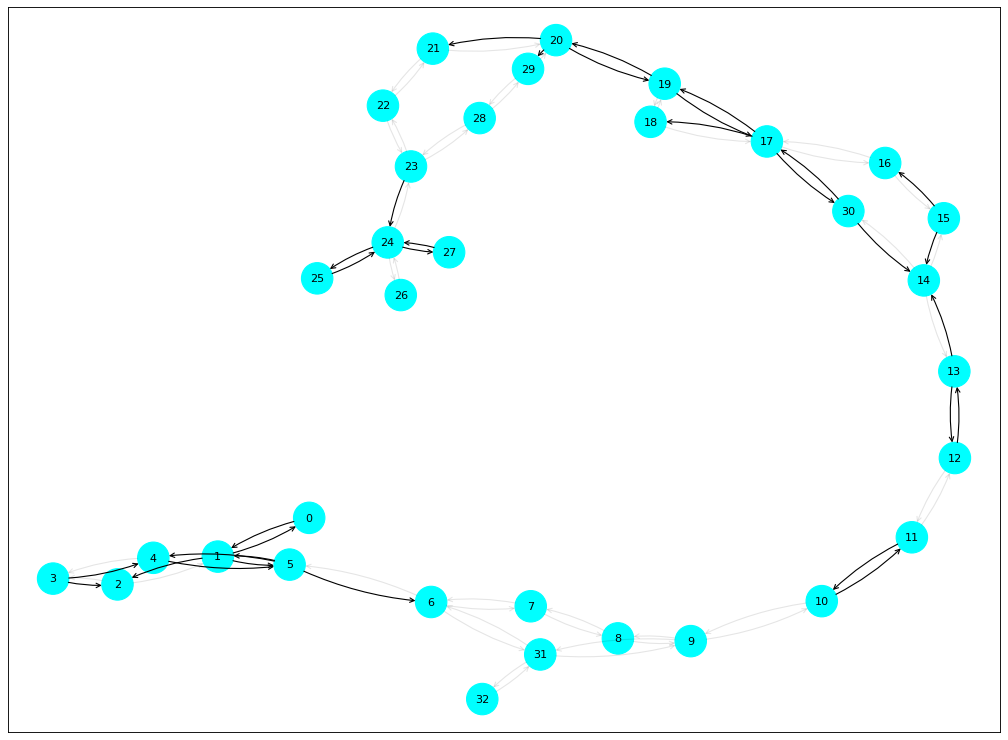

In [47]:
from matplotlib.pyplot import figure

figure(figsize=(16, 12), dpi=80)
threshold = 0.75
edge_mask = edge_mask.to("cpu")
ax, G = explainer.visualize_subgraph(edge_index = edge_index, edge_mask = edge_mask, node_idx = -1, y=None, threshold=threshold)

if SAVE:
    if TRAINING_SET_SPLIT == None:
        plt.savefig(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GEx_viz0", dpi=300, bbox_inches='tight')
    else:
        plt.savefig(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GEx_viz0_" + "training_split_" + str(TRAINING_SET_SPLIT), dpi=300, bbox_inches='tight')

plt.show()

tensor([[ 0],
        [ 1],
        [ 2],
        [ 3],
        [ 6],
        [ 7],
        [ 9],
        [10],
        [11],
        [12],
        [24],
        [25],
        [28],
        [29],
        [30],
        [34],
        [35],
        [39],
        [40],
        [41],
        [44],
        [46],
        [47],
        [48],
        [49],
        [55],
        [58],
        [60],
        [61],
        [63],
        [68],
        [69]])
tensor([[ 0,  1,  1,  1,  3,  3,  4,  5,  5,  5, 10, 11, 12, 13, 13, 15, 15, 17,
         17, 17, 19, 19, 20, 20, 20, 23, 24, 24, 25, 27, 30, 30],
        [ 1,  0,  2,  5,  2,  4,  5,  1,  4,  6, 11, 10, 13, 12, 14, 14, 16, 18,
         19, 30, 17, 20, 19, 21, 29, 24, 25, 27, 24, 24, 14, 17]],
       device='cuda:0')


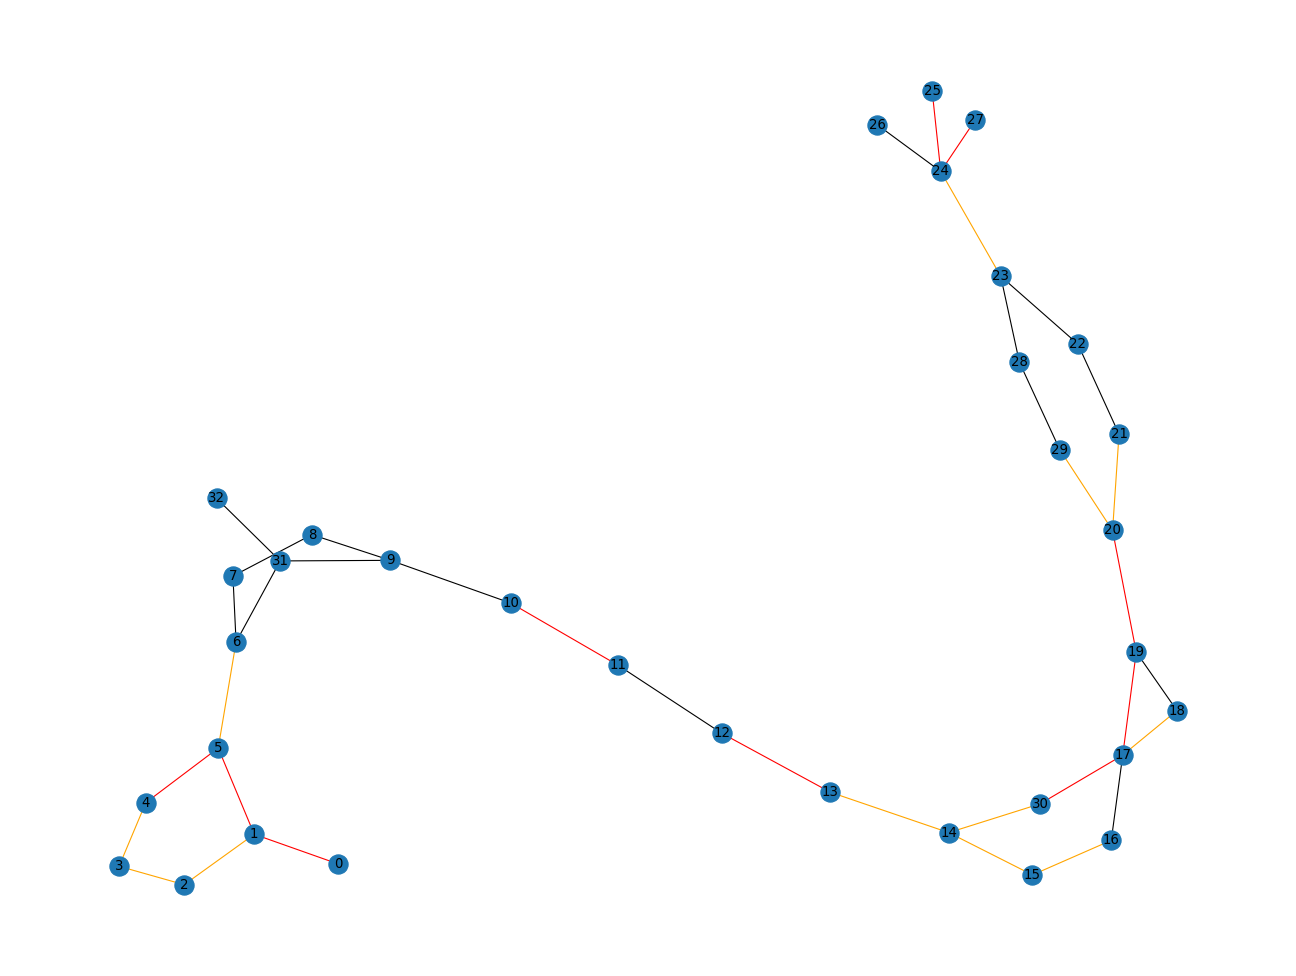

In [48]:
hard_edge_mask = (edge_mask >= threshold).to(torch.float)
hard_edge_mask.shape

important_edges_index = torch.nonzero(hard_edge_mask == 1)
print(important_edges_index)

edge_index = edge_index.to(device)
important_edges_index = important_edges_index.to(device)

important_edges = torch.index_select(edge_index, dim = 1, index = important_edges_index.squeeze())
print(important_edges)

edges_color = []
mol = read_smiles(test_cpd.smiles)

for edge in mol.edges:
    found_from = False
    found_to = False
    for i in range(important_edges.shape[1]):
        if edge[0] == important_edges[0][i] and edge[1] == important_edges[1][i]:
            found_from = True
        if edge[1] == important_edges[0][i] and edge[0] == important_edges[1][i]:
            found_to = True
    if found_from and found_to:
        edges_color.append("red")
    elif found_from or found_to:
        edges_color.append("orange")
    else:
        edges_color.append("black")   

figure(figsize=(16, 12), dpi=80)
#mol = nx.DiGraph(mol)
labels = nx.get_node_attributes(mol, 'element') 
nx.draw(mol, with_labels = True, edge_color = edges_color, pos=nx.spring_layout(mol))

if SAVE:
    if TRAINING_SET_SPLIT == None:
        plt.savefig(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GEx_viz1", dpi=300, bbox_inches='tight')
    else:
        plt.savefig(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GEx_viz1_" + "training_split_" + str(TRAINING_SET_SPLIT), dpi=300, bbox_inches='tight') 

plt.show()

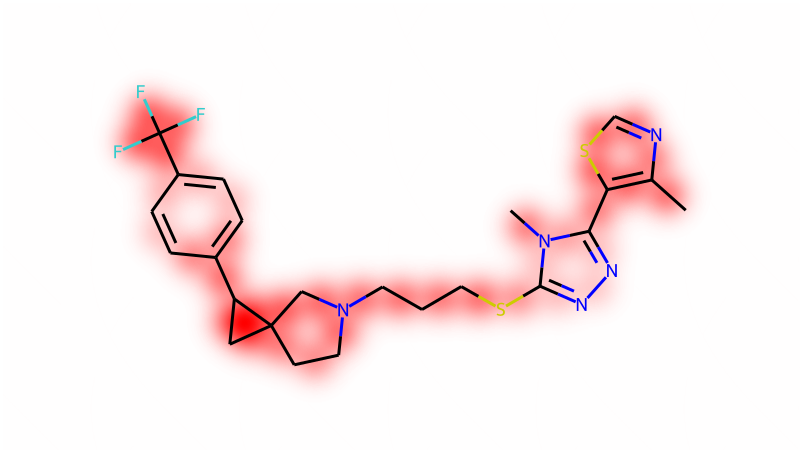

<Figure size 432x288 with 0 Axes>

In [49]:
# test_mol = Chem.MolFromSmiles(test_cpd.smiles)
# test_mol = Draw.PrepareMolForDrawing(test_mol)

# num_bonds = len(test_mol.GetBonds())
# num_atoms = len(test_mol.GetAtoms())

# rdkit_bonds = {}

# for i in range(num_bonds):
#     init_atom = test_mol.GetBondWithIdx(i).GetBeginAtomIdx()
#     end_atom = test_mol.GetBondWithIdx(i).GetEndAtomIdx()
#     bond_type = test_mol.GetBondWithIdx(i).GetBondType()
#     #print("Bond: ", i, " " , init_atom, "-" , end_atom, " ", bond_type)
#     rdkit_bonds[(init_atom, end_atom)] = i

rdkit_bonds_GNNExpl_importance = [0]*num_bonds
for i in range(len(edge_mask)):
    GNNExpl_importance_value = edge_mask[i]
    init_atom = edge_index[0][i].item()
    end_atom = edge_index[1][i].item()
    
    if (init_atom, end_atom) in rdkit_bonds:
        bond_index = rdkit_bonds[(init_atom, end_atom)]
        rdkit_bonds_GNNExpl_importance[bond_index] += GNNExpl_importance_value.item()
    if (end_atom, init_atom) in rdkit_bonds:
        bond_index = rdkit_bonds[(end_atom, init_atom)]
        rdkit_bonds_GNNExpl_importance[bond_index] += GNNExpl_importance_value.item()

plt.clf()
canvas = mapvalues2mol(test_mol, None, rdkit_bonds_GNNExpl_importance, atom_width=0.2, bond_length=0.5, bond_width=0.5) #TBD: only one direction for edges? bonds weights is wrt rdkit bonds order?
img = transform2png(canvas.GetDrawingText())

if SAVE:
    if TRAINING_SET_SPLIT == None:
        img.save(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GEx_" + "heatmap.png")
    else:
        img.save(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GEx_" + "training_split_" + str(TRAINING_SET_SPLIT) + "_heatmap.png") 
img

## Pertinent Positive/Negative Set

### pertinent negative

In [37]:
pertinent_set_indices = []
pertinent_set_edge_index = None
edge_index = E.to(device)
print("Complete graph predicts class: ", target_class)

model.eval()
for i in range(important_edges_ranking.shape[0]):
    index_of_edge_to_remove = important_edges_ranking[i]
    pertinent_set_indices.append(index_of_edge_to_remove)

    reduced_edge_index = torch.index_select(edge_index, dim = 1, index = torch.LongTensor(important_edges_ranking[i:]).to(device))
    
    # all nodes belong to same graph
    batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
    out = model(test_cpd.x, reduced_edge_index, batch=batch)
    out_prob = F.softmax(out, dim = 1)
    print(out_prob)
    predicted_class = torch.argmax(out_prob[0]).item()

    if predicted_class != target_class:
        break

pertinent_set_edge_index = torch.index_select(edge_index, dim = 1, index = torch.LongTensor(pertinent_set_indices).to(device))
print(pertinent_set_indices)
print(pertinent_set_edge_index)

with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "a") as saveFile:
        saveFile.write("\nPertinent Negative Set:\n")
        saveFile.write("Pertinent set indices on edge ranking: " + str(pertinent_set_indices))
        saveFile.write("\nPertinent set edge index: " + str(pertinent_set_edge_index))

Complete graph predicts class:  0
tensor([[1.0000e+00, 1.9173e-10]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[9.9998e-01, 1.5901e-05]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.9458, 0.0542]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.6120, 0.3880]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.0681, 0.9319]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
[32, 38, 45, 33, 61]
tensor([[14, 17, 19, 14, 25],
        [15, 16, 18, 30, 24]], device='cuda:0')


### pertinent positive

In [38]:
for i in range(important_edges_ranking.shape[0]+1):
    reduced_edge_index = torch.index_select(edge_index, dim = 1, index = torch.LongTensor(important_edges_ranking[0:i]).to(device))
    batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
    out = model(test_cpd.x, reduced_edge_index, batch=batch)
    out_prob = F.softmax(out, dim = 1)
    # print(out_prob)
    predicted_class = torch.argmax(out_prob[0]).item()
    if (predicted_class == target_class):
        print(i)
        print(reduced_edge_index)
        print(out_prob)
        with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "a") as saveFile:
            saveFile.write("\nPertinent Positive Set:\n")
            saveFile.write("\nPertinent set edge index: " + str(reduced_edge_index))
        break

2
tensor([[14, 17],
        [15, 16]], device='cuda:0')
tensor([[0.6194, 0.3806]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
